# [**Interpolation polynomiale et par spline**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/6_3_preprocessing/plot_polynomial_interpolation.ipynb)<br/>([_Polynomial and Spline interpolation_](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html))

Cet exemple montre comment approximer une fonction à l'aide de polynômes jusqu'à un certain degré en utilisant la régression Ridge. Nous montrons deux différentes approches pour un ensemble de `n_samples` points $x_i$ à une dimension :

[**`PolynomialFeatures`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) génère tous les monômes jusqu'au degré `degree` spécifié. Cela nous donne la matrice de Vandermonde, également appelée matrice de pseudo-variables, avec `n_samples` lignes et `degree + 1` colonnes :

```python
[[1, x_0, x_0 ** 2, x_0 ** 3, ..., x_0 ** degree],
 [1, x_1, x_1 ** 2, x_1 ** 3, ..., x_1 ** degree],
 ...]
```

Intuitivement, cette matrice peut être interprétée comme une matrice de pseudo-variables (les points élevés à une certaine puissance). La matrice ressemble (mais est différente) à la matrice induite par un noyau polynomial.

[**`SplineTransformer`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html) génère des fonctions de base de B-spline. Une fonction de base d'une B-spline est une fonction polynomiale par morceaux de degré `degree` spécifié qui est différente de zéro uniquement entre `degree+1` nœuds consécutifs. Avec `n_knots` nombre de nœuds, cela donne une matrice de `n_samples` lignes et `n_knots + degree - 1` colonnes :

```python
[[basis_1(x_0), basis_2(x_0), ...],
 [basis_1(x_1), basis_2(x_1), ...],
 ...]
```

Cet exemple montre que ces deux transformateurs sont adaptés pour modéliser des effets non linéaires avec un modèle linéaire, en utilisant un pipeline pour ajouter des caractéristiques non linéaires. Les méthodes de noyau étendent cette idée et peuvent induire des espaces de caractéristiques de très grande dimension (voire infinis).

In [2]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

Nous commençons par définir une fonction que nous souhaitons approximer et préparons sa représentation graphique.

In [3]:
def f(x):
    """Function to be approximated by polynomial interpolation."""
    return x * np.sin(x)


# whole range we want to plot
x_plot = np.linspace(-1, 11, 100)

Pour rendre les choses intéressantes, nous utilisons seulement un petit sous-ensemble de points pour l'entraînement.

In [4]:
x_train = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=20, replace=False))
y_train = f(x_train)

# create 2D-array versions of these arrays to feed to transformers
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

Nous sommes maintenant prêts à créer des caractéristiques polynomiales et des splines, à les ajuster sur les points d'entraînement et à montrer à quel point ils assurent une interpolation.

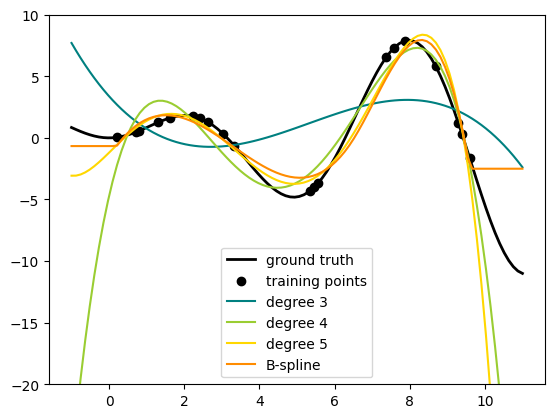

In [5]:
# plot function
lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

# plot training points
ax.scatter(x_train, y_train, label="training points")

# polynomial features
for degree in [3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label=f"degree {degree}")

# B-spline with 4 + 3 - 1 = 6 basis functions
model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
model.fit(X_train, y_train)

y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, label="B-spline")
ax.legend(loc="lower center")
ax.set_ylim(-20, 10)
plt.show()

Cela montre clairement que des polynômes de degré plus élevé peuvent mieux ajuster les données. Mais en même temps, des puissances trop élevées peuvent montrer un comportement oscillatoire indésirable et sont particulièrement dangereuses pour l'extrapolation en dehors de la plage des données ajustées. C'est là qu'interviennent les B-splines. Elles s'ajustent généralement aussi bien aux données que les polynômes et présentent un comportement très lisse. Elles offrent également de bonnes options pour contrôler l'extrapolation, qui est par défaut continue avec une constante. Notez que le plus souvent, vous préféreriez augmenter le nombre de nœuds tout en maintenant `degree=3`.

Afin de mieux comprendre les bases de caractéristiques générées, nous traçons séparément toutes les colonnes des deux transformateurs.

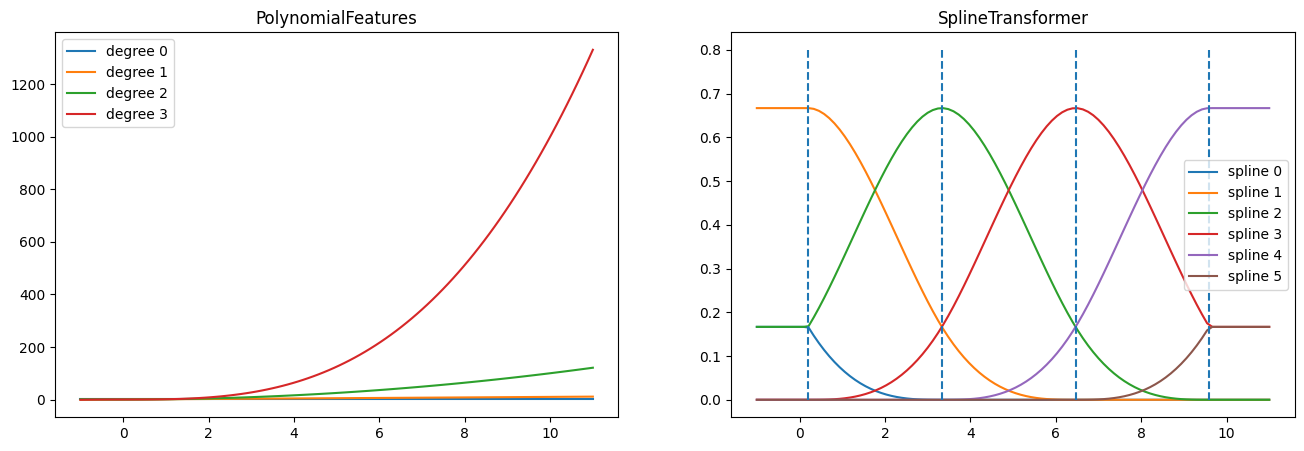

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
pft = PolynomialFeatures(degree=3).fit(X_train)
axes[0].plot(x_plot, pft.transform(X_plot))
axes[0].legend(axes[0].lines, [f"degree {n}" for n in range(4)])
axes[0].set_title("PolynomialFeatures")

splt = SplineTransformer(n_knots=4, degree=3).fit(X_train)
axes[1].plot(x_plot, splt.transform(X_plot))
axes[1].legend(axes[1].lines, [f"spline {n}" for n in range(6)])
axes[1].set_title("SplineTransformer")

# plot knots of spline
knots = splt.bsplines_[0].t
axes[1].vlines(knots[3:-3], ymin=0, ymax=0.8, linestyles="dashed")
plt.show()

Dans le graphe de gauche, on reconnaît les lignes correspondant aux monômes simples de `x**0` à `x**3`. Sur la figure de droite, on voit les six fonctions de base B-spline de `degree=3` ainsi que les quatre positions des nœuds choisies lors de `fit`. Notez qu'il y a `degree` nœuds supplémentaires à gauche et à droite de l'intervalle ajusté. Ils sont là pour des raisons techniques, nous évitons de les afficher. Chaque fonction de base a un support local et est prolongée en tant que constante au-delà de la plage ajustée. Ce comportement d'extrapolation peut être modifié en utilisant l'argument `extrapolation`.

# Splines périodiques

Dans l'exemple précédent, nous avons constaté les limites des polynômes et des splines pour l'extrapolation en dehors de la plage des observations d'entraînement. Dans certains cas, par exemple avec des effets saisonniers, nous nous attendons à une continuation périodique du signal sous-jacent. De tels effets peuvent être modélisés à l'aide de splines périodiques, qui ont des valeurs de fonction égales et des dérivées égales au premier et au dernier nœud. Dans le cas suivant, nous montrons comment les splines périodiques permettent un meilleur ajustement à la fois à l'intérieur et à l'extérieur de la plage des données d'entraînement en utilisant les informations supplémentaires de périodicité. La période des splines correspond à la distance entre le premier et le dernier nœud, que nous spécifions manuellement.

Les splines périodiques peuvent également être utiles pour des caractéristiques naturellement périodiques (comme le jour de l'année), car la régularité aux nœuds limites empêche un saut dans les valeurs transformées (par exemple, du 31 décembre au 1er janvier). Pour de telles caractéristiques naturellement périodiques ou plus généralement pour des caractéristiques dont la période est connue, il est conseillé de passer explicitement cette information au [**`SplineTransformer`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html) en définissant les nœuds manuellement.

C:\Users\franc\AppData\Local\Temp\ipykernel_43620\3180212657.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


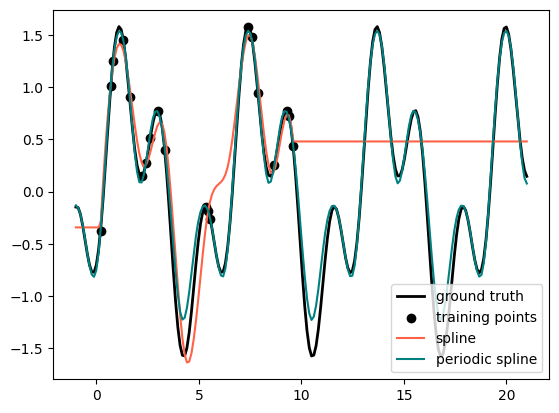

In [7]:
def g(x):
    """Function to be approximated by periodic spline interpolation."""
    return np.sin(x) - 0.7 * np.cos(x * 3)


y_train = g(x_train)

# Extend the test data into the future:
x_plot_ext = np.linspace(-1, 21, 200)
X_plot_ext = x_plot_ext[:, np.newaxis]

lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(color=["black", "tomato", "teal"])
ax.plot(x_plot_ext, g(x_plot_ext), linewidth=lw, label="ground truth")
ax.scatter(x_train, y_train, label="training points")

for transformer, label in [
    (SplineTransformer(degree=3, n_knots=10), "spline"),
    (
        SplineTransformer(
            degree=3,
            knots=np.linspace(0, 2 * np.pi, 10)[:, None],
            extrapolation="periodic",
        ),
        "periodic spline",
    ),
]:
    model = make_pipeline(transformer, Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot_ext = model.predict(X_plot_ext)
    ax.plot(x_plot_ext, y_plot_ext, label=label)

ax.legend()
fig.show()

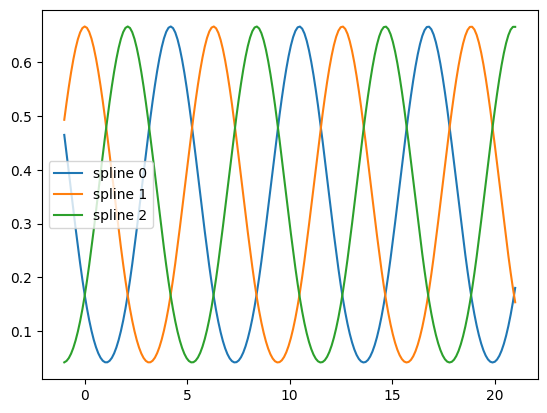

In [8]:
fig, ax = plt.subplots()
knots = np.linspace(0, 2 * np.pi, 4)
splt = SplineTransformer(knots=knots[:, None], degree=3, extrapolation="periodic").fit(
    X_train
)
ax.plot(x_plot_ext, splt.transform(X_plot_ext))
ax.legend(ax.lines, [f"spline {n}" for n in range(3)])
plt.show()